In [11]:
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.tri import Triangulation
from scipy.interpolate import LinearNDInterpolator

USER = os.getenv('USER')

In [2]:
def jacobian(x0, y0, x1, y1, x2, y2):
    """
    jac = jacobian(x0, y0, x1, y1, x2, y2):
    calculates jac = det(M),
    where M is the matrix
    [[x1-x0, y1-y0], [x2-x0, y2-y0]].

    This is twice the area of a triangle with vertices:
    (x0, y0), (x1, y1), (x2, y2)

    Parameters:
    x0, x1, x2 (numpy arrays or floats) - x coords of the 3 points
    y0, y1, y2 (numpy arrays or floats) - y coords of the 3 points

    Returns:
    jac (same type as inputs)
    """
    return (x1-x0)*(y2-y0)-(x2-x0)*(y1-y0)

In [3]:
# find matching coordinates on the first and second snapshots

nfile0 = f'../../example_data/field_20230101T120000Z.npz'
d0 = dict(np.load(nfile0))
nfile1 = f'../../example_data/field_20230101T230000Z.npz'
d1 = dict(np.load(nfile1))

# find common nodes on the first and the second files
_, comm0, comm1 = np.intersect1d(d0['i'], d1['i'], assume_unique=True, return_indices=True)

# get common X, Y coordinates
x0 = d0['x'][comm0]
y0 = d0['y'][comm0]
x1 = d1['x'][comm1]
y1 = d1['y'][comm1]

In [4]:
# create subsampled mesh for matching nodes only
t0 = Triangulation(x0, y0).triangles
# find starting / ending coordinates for each elements
x0a, x0b, x0c = x0[t0].T
y0a, y0b, y0c = y0[t0].T
x1a, x1b, x1c = x1[t0].T
y1a, y1b, y1c = y1[t0].T

In [5]:
# compute area at the first and second snapshots (subsampled mesh)
a0 = jacobian(x0a, y0a, x0b, y0b, x0c, y0c)
a1 = jacobian(x1a, y1a, x1b, y1b, x1c, y1c)

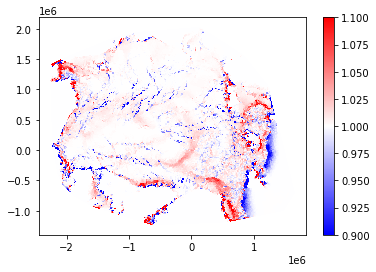

In [28]:
# plot ratio of areas (subsampled mesh)
area_ratio = a0 / a1
plt.tripcolor(x0, y0, area_ratio, triangles=t0, vmin=0.9, vmax=1.1, cmap='bwr')
plt.colorbar()

In [17]:
# original mesh data at time 0
sic0n = d0['Concentration']
t0n = d0['t']
x0n = d0['x']
y0n = d0['y']
elx0n = x0n[t0n].mean(axis=1)
ely0n = y0n[t0n].mean(axis=1)

In [32]:
# interpolate SIC from original mesh elements to the subsampled mesh elements
x0e = x0[t0].mean(axis=1)
y0e = y0[t0].mean(axis=1)

sic_interpolator = LinearNDInterpolator((elx0n, ely0n), sic0n)
sic0 = sic_interpolator((x0e, y0e))

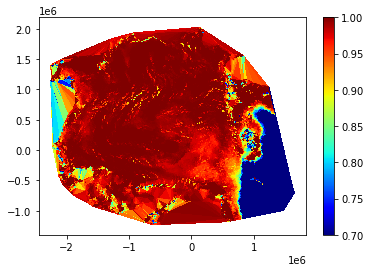

In [51]:
# interpolated SIC at time 0 (subsampled mesh)
plt.tripcolor(x0, y0, sic0, triangles=t0, vmin=0.7, vmax=1.0, cmap='jet')
plt.colorbar()

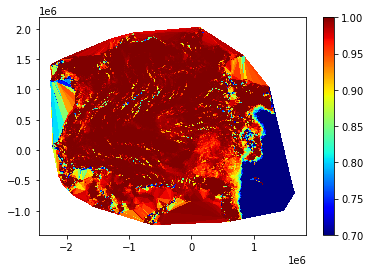

In [50]:
# new SIC (after convergence / divergence) (subsampled mesh)
sic1comp = np.clip(sic0 * area_ratio, 0, 1)
plt.tripcolor(x0, y0, sic1comp, triangles=t0, vmin=0.7, vmax=1.0, cmap='jet')
plt.colorbar()

# the same for SIT but without clipping

In [52]:
# original mesh data at time 1
sic1n = d1['Concentration']
t1n = d1['t']
x1n = d1['x']
y1n = d1['y']
elx1n = x1n[t1n].mean(axis=1)
ely1n = y1n[t1n].mean(axis=1)

In [53]:
# interpolate SIC computed with divergence from subsampled mesh to original mesh at time 1
x1e = x1[t0].mean(axis=1)
y1e = y1[t0].mean(axis=1)

sic_comp_interpolator = LinearNDInterpolator((x1e, y1e), sic1comp)
sic1comp_n = sic_interpolator((elx1n, ely1n))

In [59]:
# interpolate SIC WITHOUT accounting divergence from subsampled mesh to original mesh at time 1
sic_interpolator = LinearNDInterpolator((x1e, y1e), sic0)
sic01_n = sic_interpolator((elx1n, ely1n))

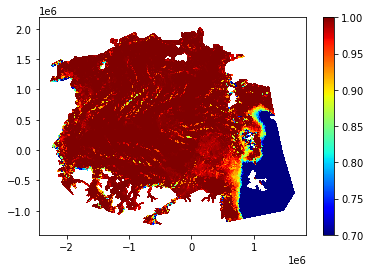

In [54]:
# nextsim simulated SIC at time 1
plt.tripcolor(x1n, y1n, sic1n, triangles=t1n, vmin=0.7, vmax=1.0, cmap='jet')
plt.colorbar()

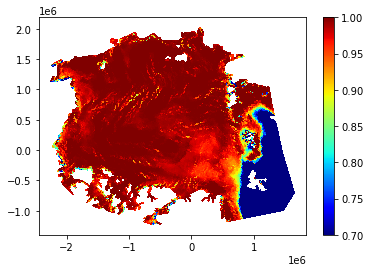

In [55]:
# SIC computed wrt divergence / convergence
plt.tripcolor(x1n, y1n, sic1comp_n, triangles=t1n, vmin=0.7, vmax=1.0, cmap='jet')
plt.colorbar()

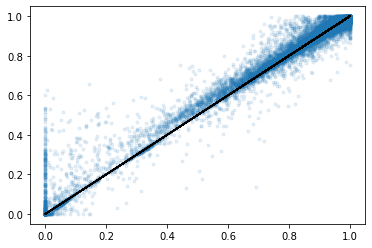

In [63]:
# compare SIC with and without accounting for divergence
plt.plot(sic01_n, sic1comp_n, '.', alpha=0.1)
plt.plot(sic01_n, sic01_n, 'k-')

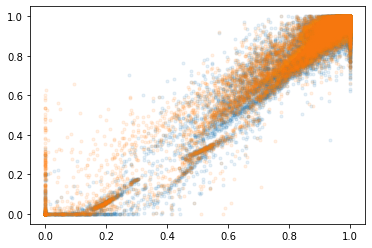

In [64]:
# compare SIC with and without accounting for divergence with the neXtSIM simulated one
plt.plot(sic1n, sic01_n, '.', alpha=0.1)
plt.plot(sic1n, sic1comp_n, '.', alpha=0.1)